In [1]:
import torch.optim as optim
from helper_DinoV2_Embeddings import *
from helper_classifier import prepare_data, get_datasets, train_model, evaluate_model, train_wb
from helper_classifier import DressCategoriesDataset, ClassifierModel

root_path = f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/"

In [2]:
target_feature = 'color'
retrain = True

In [3]:
embeddings, df = extract_embeddings()
df, id2label, label2id = prepare_data(df, target_feature)
train_dataset, test_dataset = get_datasets(df, embeddings)

Loading embeddings from disk...
14060 embeddings loaded from disk...


### Train with best hyperparamaters

In [5]:
NUM_EPOCHS = 10
BATCH_SIZE = 16
LR = 0.005

device = set_device()

loss_fn = nn.CrossEntropyLoss()
model = ClassifierModel(embeddings.shape[1], len(label2id)).to(device)
optimizer = optim.SGD(model.parameters(), lr=LR)

save_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/dinov2_{target_feature}_classifier.pt"
if not os.path.exists(save_path) or retrain:
    train_model(model, NUM_EPOCHS, BATCH_SIZE, optimizer, loss_fn, train_dataset, test_dataset, save_path, device)

Using device: mps
Epoch 1/10, Loss: 1.4304845333099365, Train Accuracy: 0.509068278805121, Test Accuracy: 0.49822190611664297
Epoch 2/10, Loss: 0.7891862392425537, Train Accuracy: 0.5812588904694168, Test Accuracy: 0.5689900426742532
Epoch 3/10, Loss: 1.112177848815918, Train Accuracy: 0.6499822190611664, Test Accuracy: 0.628022759601707
Epoch 4/10, Loss: 0.99360191822052, Train Accuracy: 0.6942567567567568, Test Accuracy: 0.6696301564722618
Epoch 5/10, Loss: 0.46068769693374634, Train Accuracy: 0.7233285917496444, Test Accuracy: 0.6927453769559033
Epoch 6/10, Loss: 1.0364015102386475, Train Accuracy: 0.7304409672830725, Test Accuracy: 0.6959459459459459
Epoch 7/10, Loss: 0.643452525138855, Train Accuracy: 0.7476884779516358, Test Accuracy: 0.6987908961593172
Epoch 8/10, Loss: 0.6087297201156616, Train Accuracy: 0.7817389758179232, Test Accuracy: 0.716927453769559
Epoch 9/10, Loss: 0.6895514726638794, Train Accuracy: 0.7702702702702703, Test Accuracy: 0.7030583214793741
Epoch 10/10, Lo

### Check Model Performance

In [6]:
model = torch.load(save_path)
model = model.to(device)

embeddings = torch.load(f"{DATA_PATH}/Models/Assessor/DinoV2/Embeddings/dinov2_embeddings.pt")
embedding = embeddings.to(device)

In [7]:
for i in tqdm(range(df.shape[0])):
    embedding = embeddings[i,:]
    embedding = embedding.to(device)
    label = df.iloc[i]['label']
    with torch.no_grad():
        output = model(embedding)
        prob, predicted = torch.max(softmax(output.data, 0), 0)
        df.loc[i, 'predicted_label'] = predicted.item()
        df.loc[i, 'predicted_prob'] = prob.item()

df['predicted_category'] = df.predicted_label.map(id2label)

  0%|          | 0/14060 [00:00<?, ?it/s]

In [8]:
train_acc = evaluate_model(model, DataLoader(train_dataset, batch_size=32, shuffle=False), device)
test_acc = evaluate_model(model, DataLoader(test_dataset, batch_size=32, shuffle=False), device)
print(f"Train Accuracy: {np.round(train_acc*100, 2)}%, Test Accuracy: {np.round(test_acc*100, 2)}%")

Train Accuracy: 80.45%, Test Accuracy: 73.04%


In [9]:
import pandas as pd
from sklearn.metrics import accuracy_score
overall_accuracy = accuracy_score(df['label'], df['predicted_label'])
print(f"Overall Accuracy: {overall_accuracy:.2%}")

Overall Accuracy: 78.97%


In [10]:
# Function to calculate accuracy for a group
def group_accuracy(group):
    return accuracy_score(group['label'], group['predicted_label'])

# Calculate accuracy for each category
group_accuracy = df.groupby(target_feature).apply(group_accuracy).sort_values(ascending=False)

# Print the accuracy for each category
print("Accuracy by Group:")
print(group_accuracy)

Accuracy by Group:
color
black     0.950540
brown     0.872093
white     0.848214
blue      0.846154
green     0.834286
beige     0.754513
pink      0.720930
red       0.679612
orange    0.679167
silver    0.607843
grey      0.526141
purple    0.525896
yellow    0.429825
gold      0.258065
dtype: float64


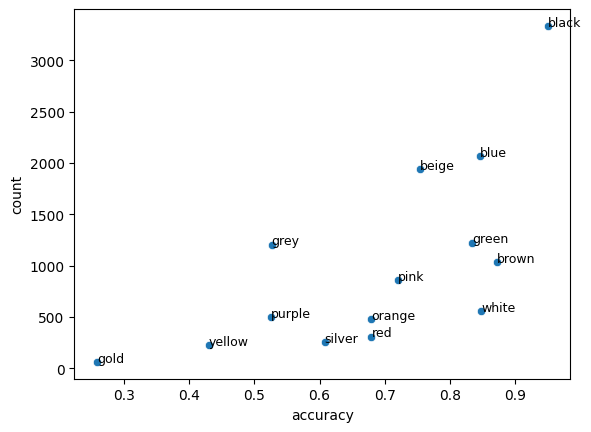

In [11]:
plot_data = pd.DataFrame(group_accuracy).reset_index().rename(columns={0: 'accuracy'}).merge(df[target_feature].value_counts().reset_index())
# Plot accuracy against number of samples and name each dot
plt.figure()
import seaborn as sns
sns.scatterplot(data=plot_data, x='accuracy', y='count')
for i in range(plot_data.shape[0]):
    plt.text(plot_data.accuracy[i], plot_data['count'][i], plot_data[target_feature][i], fontsize=9)

In [12]:
# Print confusion matrix
confusion_matrix = pd.crosstab(df['predicted_category'], df[target_feature], rownames=['Predicted'], colnames=['Actual'])
confusion_matrix

Actual,beige,black,blue,brown,gold,green,grey,orange,pink,purple,red,silver,white,yellow
Predicted,,,,,,,,,,,,,,
beige,1463,4,11,20,8,31,104,10,50,12,0,28,54,35
black,6,3171,95,39,3,7,93,2,1,10,0,16,2,1
blue,20,32,1749,6,0,80,109,5,0,75,0,10,10,6
brown,136,88,23,900,16,47,126,35,54,62,28,5,0,18
gold,3,1,0,1,16,0,0,0,1,0,1,0,0,0
green,62,8,104,18,2,1022,74,2,3,13,0,10,2,21
grey,38,12,30,8,3,11,634,0,1,3,1,19,1,0
orange,16,2,2,7,1,6,1,326,44,5,31,0,0,40
pink,94,1,5,8,1,0,3,52,620,33,28,0,6,9


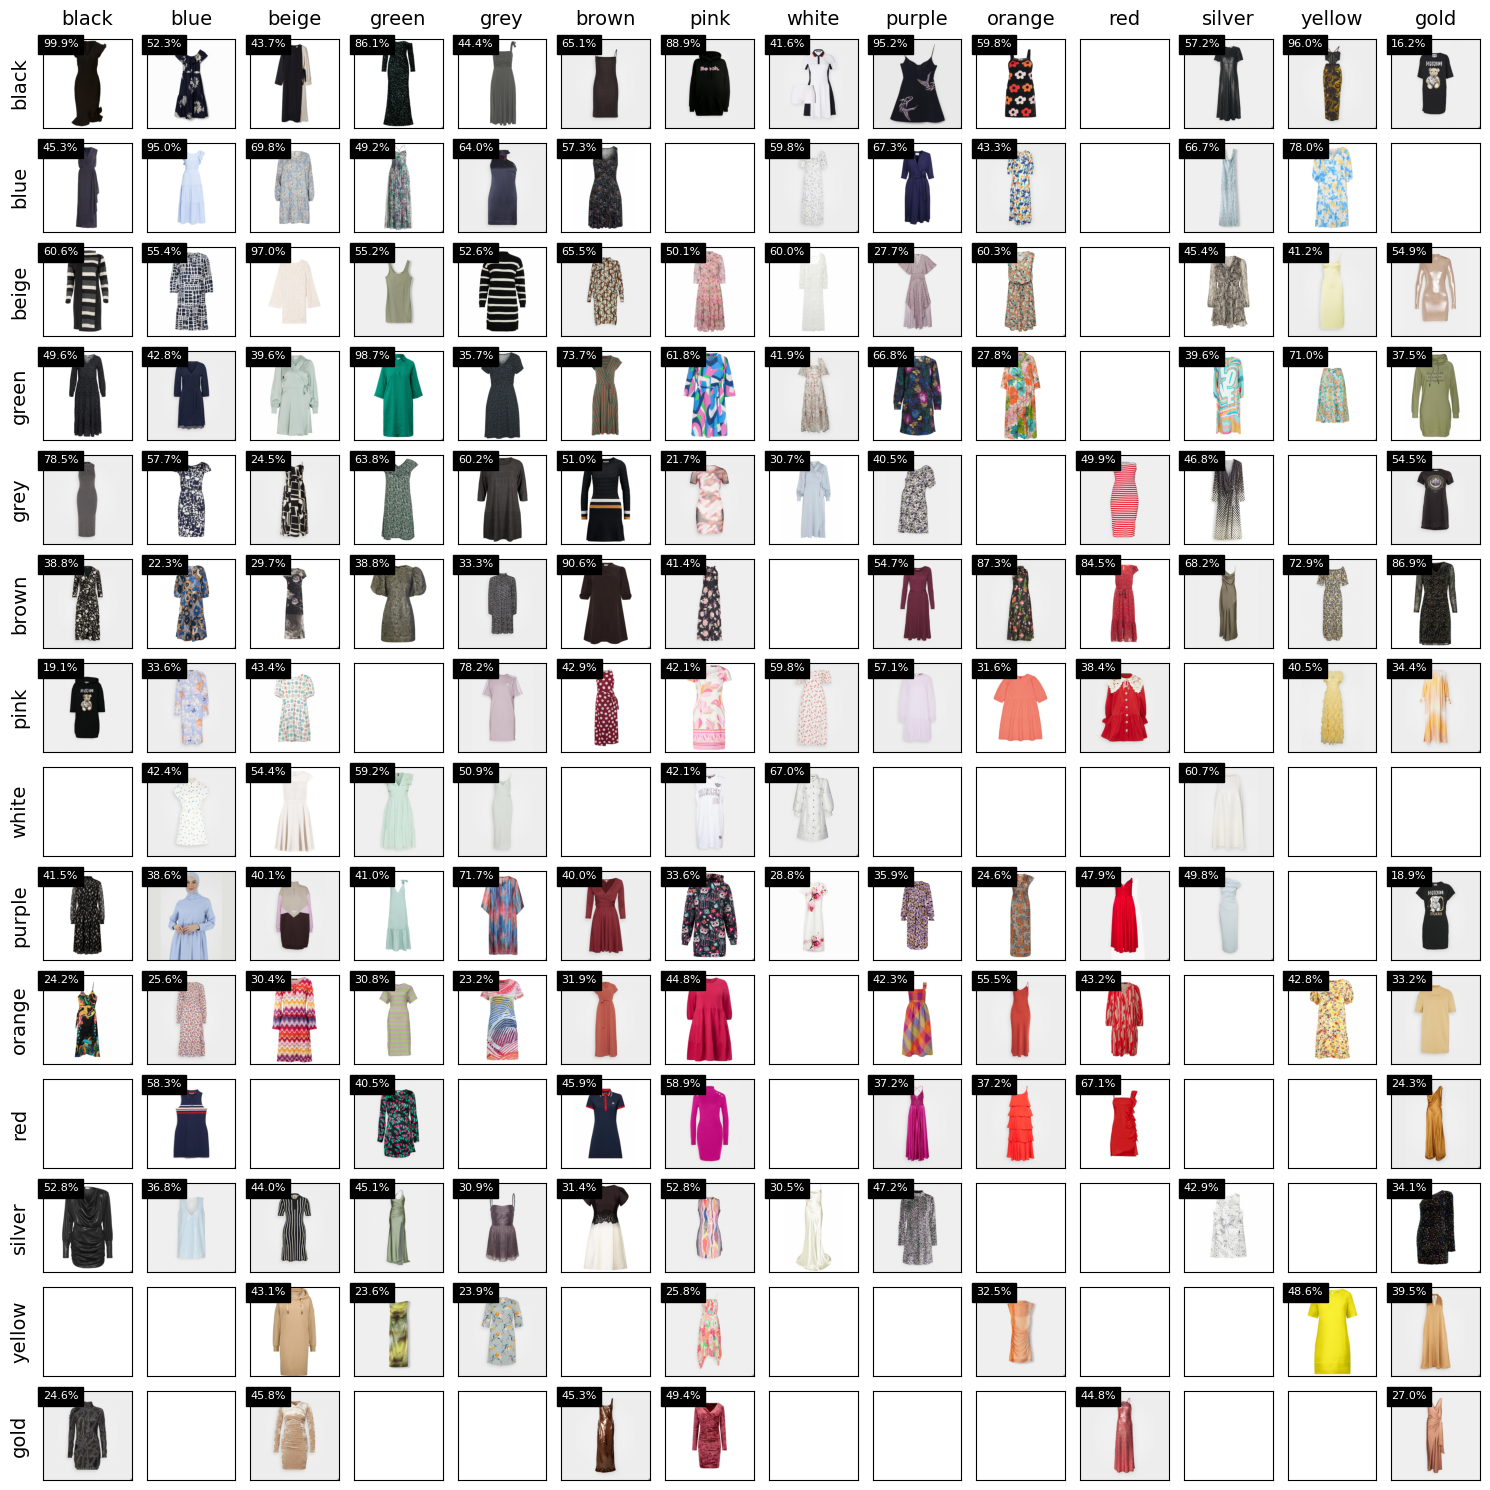

In [13]:
# Below I will plot some examples of images and their predicted labels. 
# The columns will be the actual classes
# The rows will be the predicted classes
# For each combination there will be one random sample image displayed
# The title will be the probability of the predicted class
# If there are no samples in the class, the plot will be empty
# The columns are titled with the actual class
# The rows are titled with the predicted class
root_path = f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/"
fig, axs = plt.subplots(len(id2label), len(id2label), figsize=(15, 15))

for i in range(len(id2label)):  # rows in the subplot grid
    for j in range(len(id2label)):  # columns in the subplot grid
        subset = df[(df['label'] == i) & (df['predicted_label'] == j)]
        if not subset.empty:
            sample = subset.sample(1)
            img_path = f"{root_path}{sample['sku'].item()}.jpg"
            img = Image.open(img_path)
            axs[j, i].imshow(img)
            axs[j, i].text(0, 0, f'{np.round(sample.predicted_prob.item()*100,1)}%', color='white', backgroundcolor='black', fontsize=8, verticalalignment='top')
        #axs[j, i].axis('off')
        axs[j, i].set_xticks([])  # Ensure no ticks
        axs[j, i].set_yticks([])
        axs[j, 0].set_ylabel(id2label[j], labelpad=10, fontsize=14)


    # Set labels with a larger font and some padding for better visibility
    axs[0, i].set_title(id2label[i], pad=10, fontsize=14)
    



plt.tight_layout()
plt.show()
